In [3]:
import os
import sys

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import torch
import torchvision.models as models
import torch.nn as nn
import cv2
import re



In [4]:

label_root = "../../Labelling/Lemurs/labelling_app_indID/raw_labels/"
files_in_label_root = os.listdir(label_root)

group = "R1"

path_to_videos = f"/usr/users/vogg/sfb1528s3/B06/2023april-july/NewBoxesClosed/Converted/{group}/"
data_root = Path(f"/usr/users/vogg/Labelling/Lemurs/labelling_app_indID/richard_sorted/{group}")


In [5]:

#group_long = "R1" if group == "R" else "Alpha" if group == "A" else group

#filename = next((f for f in files_in_label_root if exp in f), None)
# Initialize an empty DataFrame with the specified columns
columns = ['trackNumber', 'trackId', 'xCoord', 'yCoord', 'width', 'height', 'confidenceTrack', 'species', 'nameOrder', 'confidenceId', 'experiment']
combined_df = pd.DataFrame(columns=columns)

files_starting_with_A = [f for f in files_in_label_root if f.startswith(group[0])]

for i, filename in enumerate(files_starting_with_A):

    file_path = f"{label_root}/{filename}"

    with open(file_path, "r") as file:
        file_content = file.readlines()

    metadata = [line.strip("#").strip() for line in file_content if line.startswith("#")]
    metadata_dict = dict(item.split(": ") for item in metadata)

    username = metadata_dict["username"]
    editDate = metadata_dict["editDate"]
    orderedNames = metadata_dict["orderedNames"].split(", ")
    if i > 0:
        if orderedNames != previous_orderedNames:
            print(f"Warning: orderedNames in {filename} do not match the previous file.")
    previous_orderedNames = orderedNames
    dataColumns = metadata_dict["dataColumns"].split(", ")

    df_id = pd.read_csv(file_path, skiprows=len(metadata), names=dataColumns).sort_values(["species", "trackId", "trackNumber"])

    filtered_df_id = df_id[df_id['species'] == 0]

    filtered_df_id = filtered_df_id.copy()
    filtered_df_id['experiment'] = '_'.join(filename.split('_', 3)[:3])

    # Append the filtered DataFrame to the combined DataFrame
    combined_df = pd.concat([combined_df, filtered_df_id], ignore_index=True)

/tmp/ipykernel_841913/715484942.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat([combined_df, filtered_df_id], ignore_index=True)


In [6]:
# Get the indices for 'Uns' and 'Unsure' from the orderedNames list
uns_index = orderedNames.index('Uns')
unsure_index = orderedNames.index('Unsure')

# Merge the nameOrder numbers that belong to Uns and Unsure
combined_df['nameOrder'] = combined_df['nameOrder'].replace({uns_index: unsure_index})
combined_df.sample(10)

/tmp/ipykernel_841913/2766239588.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_df['nameOrder'] = combined_df['nameOrder'].replace({uns_index: unsure_index})


trackNumber trackId       xCoord      yCoord       width      height  \
315024       23867      44   373.408017  416.230799  242.272180  201.441654   
192082       14221      21  1065.702782  337.564643  407.569891  396.747186   
477998       27634      41   428.254093  409.152449  132.535964  111.086565   
538359       26395      57  1575.521595  295.332029  214.451921  226.954720   
390201        8317      35  1490.324284  448.677534   68.720308   80.779986   
273636       23959      27  1827.435060  590.170958   95.890753  118.565066   
94090        27323      29   743.794673  217.507842  302.688828  336.061976   
570619       11252      18   805.672881  251.396320  318.545689  270.197843   
650248       24707      32  1738.416704  387.684286   97.080682  169.684013   
622579       18408      42   168.425167  345.684166  128.387988  155.469631   

        confidenceTrack species  nameOrder confidenceId experiment  
315024         0.957171       0          3            1    R_e1_c4  
192082         0.390386       0          6            1    R_e3_c4  
477998         0.597467       0          3            1    R_e3_c3  
538359         0.955251       0          6            1    R_e1_c2  
390201         0.848974       0          1            1    R_e5_c2  
273636         0.584350       0          2            1    R_e4_c3  
94090          0.985144       0          6            1    R_e1_c1  
570619         0.981061       0          4            1    R_e2_c1  
650248         0.699097       0          2            1    R_e4_c4  
622579         0.962301       0          0            1    R_e6_c3

In [7]:
name_order_counts = combined_df['nameOrder'].value_counts()
name_order_counts.index = name_order_counts.index.map(lambda x: f"{orderedNames[x]} ({x})")
distinct_counts = combined_df[['nameOrder', 'experiment', 'trackId']].drop_duplicates().groupby('nameOrder').size()
print(distinct_counts)
print(name_order_counts)
print(orderedNames)

nameOrder
0      22
1      66
2      63
3     132
4     134
5       8
6     144
7    1152
dtype: int64
nameOrder
Unsure (7)    217096
Ata (3)       140153
Zemlya (4)    114344
Gerald (6)     98539
Yaya (1)       57064
Novaya (2)     43452
Tiwi (0)       12243
Croker (5)      6361
Name: count, dtype: int64
['Tiwi', 'Yaya', 'Novaya', 'Ata', 'Zemlya', 'Croker', 'Gerald', 'Unsure', 'Uns']


In [8]:
model = models.resnet18()
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 2),
    nn.Softmax(dim=1)
)

state_dict = torch.load("../../efficient_individual_identification/models/binary.pth", map_location='cuda:0')
model.load_state_dict(state_dict)
model.eval();

/tmp/ipykernel_841913/4284915341.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("../../efficient_individual_identification/models/binary.pth", m

## Random search

In [26]:
for i, name in enumerate(orderedNames):
    if (name == "Uns") or (name == "Unsure"):
        continue

    print(i, name)
    selected_df = combined_df.loc[combined_df['nameOrder'] == i, :]
    step_size = int(max(len(selected_df) // 3000, 1))

    for i in np.arange(0, len(selected_df), step_size):

        if i % 1000 == 0:
            print(f"Processing row {i}")
        row = selected_df.iloc[i]
        index = row.name  # This is the index of the row in selected_df (and combined_df)
        video_path = os.path.join(path_to_videos, f"{row['experiment']}.mp4")
        cap = cv2.VideoCapture(video_path)

        if not cap.isOpened():
            print(f"Error: Could not open video {video_path}")
        else:
            frame_number = int(row['trackNumber'])
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
            ret, frame = cap.read()

            if ret:
                # Crop the bounding box from the frame
                x, y, w, h = int(row['xCoord']), int(row['yCoord']), int(row['width']), int(row['height'])
                cropped_frame = frame[y:y+h, x:x+w]

                # Resize the cropped frame to 224x224
                resized_frame = cv2.resize(frame, (224, 224), cv2.INTER_AREA)

                frame = torch.from_numpy(resized_frame).float()
                frame = frame.permute(2, 0, 1)
                img = frame / 255.0

                # Add a batch dimension and move the tensor to the same device as the model
                img = img.unsqueeze(0).to(next(model.parameters()).device)

                # Apply the model to the image
                with torch.no_grad():
                    output = model(img)
                    score = output.numpy()[0][1]
                    if score > 0.9:
                        print(f"Saving index {index} for {name}")
                        # You can append to a list, e.g. high_score_indices, or process as needed
                        if 'high_score_indices' not in locals():
                            high_score_indices = []
                        high_score_indices.append(index)


0 Tiwi
Processing row 0
Error: Could not open video /usr/users/vogg/sfb1528s3/B06/2023april-july/NewBoxesClosed/Converted/R1/R_e3_c4.mp4
Error: Could not open video /usr/users/vogg/sfb1528s3/B06/2023april-july/NewBoxesClosed/Converted/R1/R_e3_c4.mp4
Error: Could not open video /usr/users/vogg/sfb1528s3/B06/2023april-july/NewBoxesClosed/Converted/R1/R_e3_c4.mp4
Error: Could not open video /usr/users/vogg/sfb1528s3/B06/2023april-july/NewBoxesClosed/Converted/R1/R_e3_c4.mp4
Error: Could not open video /usr/users/vogg/sfb1528s3/B06/2023april-july/NewBoxesClosed/Converted/R1/R_e3_c4.mp4
Error: Could not open video /usr/users/vogg/sfb1528s3/B06/2023april-july/NewBoxesClosed/Converted/R1/R_e3_c4.mp4
Error: Could not open video /usr/users/vogg/sfb1528s3/B06/2023april-july/NewBoxesClosed/Converted/R1/R_e3_c4.mp4
Error: Could not open video /usr/users/vogg/sfb1528s3/B06/2023april-july/NewBoxesClosed/Converted/R1/R_e3_c4.mp4
Error: Could not open video /usr/users/vogg/sfb1528s3/B06/2023april-july

## Clustering attempt

In [22]:
import re

n_cluster = 50000

unsure_index = orderedNames.index('Unsure')
# Get nameOrders with counts under 2700
under_n_nameOrders = name_order_counts[name_order_counts < n_cluster].index
print(under_n_nameOrders)
under_n_nameOrders = under_n_nameOrders.map(lambda x: int(re.search(r'\((\d+)\)', x).group(1)))

print(under_n_nameOrders)


filtered_combined_df = combined_df[~combined_df['nameOrder'].isin(under_n_nameOrders) & (combined_df['nameOrder'] != unsure_index)]

Index(['Novaya (2)', 'Tiwi (0)', 'Croker (5)'], dtype='object', name='nameOrder')
Index([2, 0, 5], dtype='int64', name='nameOrder')


### Step by Step

### Clustering by camera and bbox position

Idea: remove duplicates

In [12]:

subset_df = combined_df[combined_df['nameOrder'] == 3]#.reset_index(drop=True)


# Convert the 'experiment' column to a numerical variable
subset_df['experiment_num'] = 100 * subset_df['experiment'].astype('category').cat.codes


# Normalize the variables except for experiment_num
subset_df[['xCoord_norm', 'yCoord_norm', 'width_norm', 'height_norm']] = subset_df[['xCoord', 'yCoord', 'width', 'height']].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# Select the features for clustering
features = subset_df[['xCoord_norm', 'yCoord_norm', 'width_norm', 'height_norm', 'experiment_num', 'trackId']]

# Run k-means clustering
kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(features)

# Add the cluster labels to the dataframe
subset_df['cluster'] = kmeans.labels_

np.random.seed(0)

# Group by cluster and sample one index from each cluster
sampled_indices = subset_df.groupby('cluster').apply(lambda x: x.sample(1)).index.droplevel(0)
sorted_sampled_indices = sampled_indices.sort_values()

subset_df.head(10)

/tmp/ipykernel_841913/505651182.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['experiment_num'] = 100 * subset_df['experiment'].astype('category').cat.codes
/tmp/ipykernel_841913/505651182.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df[['xCoord_norm', 'yCoord_norm', 'width_norm', 'height_norm']] = subset_df[['xCoord', 'yCoord', 'width', 'height']].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
/tmp/ipykernel_841913/505651182.py:9: SettingWithCopyWarning: 
A value is tryi

trackNumber trackId      xCoord      yCoord       width      height  \
12672        9110      17  252.576342  319.863157  223.388938  264.999917   
12673        9111      17  253.468037  320.371094  224.793690  264.063190   
12674        9112      17  256.936369  321.660752  226.270297  262.019505   
12675        9113      17  265.186861  321.320655  231.905647  262.622045   
12676        9114      17  268.117818  320.102393  238.135946  263.739675   
12677        9115      17  270.126177  321.357874  245.658064  266.693770   
12678        9116      17  269.070215  321.313958  253.043295  270.586699   
12679        9117      17  267.200619  320.564600  258.405812  273.351982   
12680        9118      17  265.875115  320.134331  261.661643  274.113326   
12681        9119      17  264.383777  319.178717  265.540267  275.033119   

       confidenceTrack species  nameOrder confidenceId experiment  \
12672         0.982910       0          3            1    R_e2_c2   
12673         0.982512       0          3            1    R_e2_c2   
12674         0.976743       0          3            1    R_e2_c2   
12675         0.978294       0          3            1    R_e2_c2   
12676         0.979374       0          3            1    R_e2_c2   
12677         0.971623       0          3            1    R_e2_c2   
12678         0.984952       0          3            1    R_e2_c2   
12679         0.989533       0          3            1    R_e2_c2   
12680         0.988704       0          3            1    R_e2_c2   
12681         0.980539       0          3            1    R_e2_c2   

       experiment_num  xCoord_norm  yCoord_norm  width_norm  height_norm  \
12672             -12     0.220625     0.529276    0.197793     0.241746   
12673             -12     0.221050     0.529905    0.199269     0.240719   
12674             -12     0.222706     0.531502    0.200820     0.238478   
12675             -12     0.226643     0.531081    0.206741     0.239138   
12676             -12     0.228041     0.529572    0.213287     0.240364   
12677             -12     0.229000     0.531127    0.221191     0.243603   
12678             -12     0.228496     0.531073    0.228951     0.247873   
12679             -12     0.227604     0.530145    0.234585     0.250905   
12680             -12     0.226971     0.529612    0.238006     0.251740   
12681             -12     0.226259     0.528428    0.242081     0.252748   

       cluster  
12672      166  
12673      166  
12674      166  
12675      166  
12676      166  
12677      166  
12678      214  
12679      214  
12680      214  
12681      214

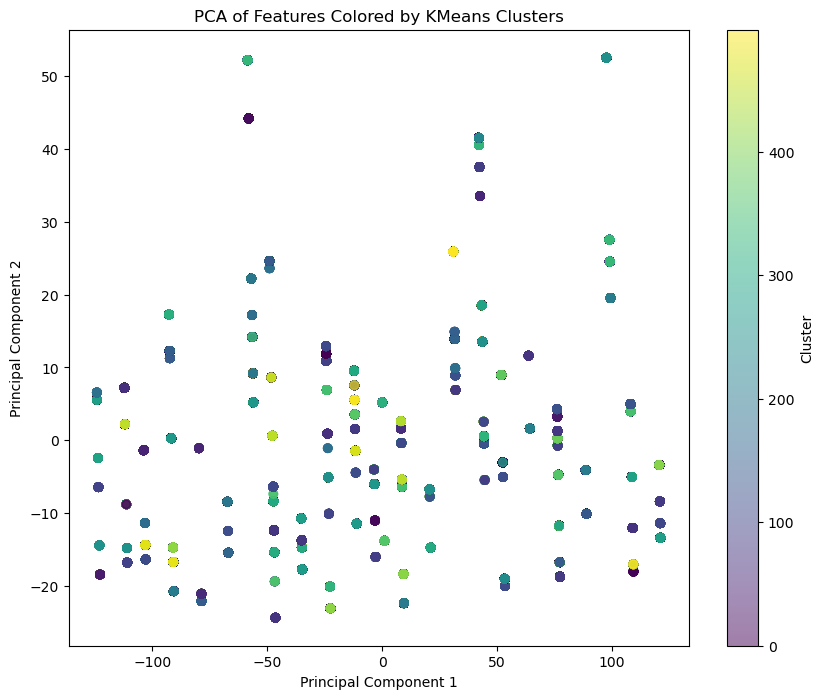

In [13]:
from sklearn.decomposition import PCA

# Perform PCA on the features
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features)

# Create a DataFrame for the PCA features
pca_df = pd.DataFrame(data=pca_features, columns=['PC1', 'PC2'])
pca_df['cluster'] = kmeans.labels_

# Plot the PCA features colored by cluster labels
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['cluster'], cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Features Colored by KMeans Clusters')
plt.show()

### Retrieve scores from sorting model

In [19]:

path_to_videos = f"/usr/users/vogg/sfb1528s3/B06/2023april-july/NewBoxesClosed/Converted/{group}/"

counter = 0
i = 0
scores = []

quintile_1 = []
quintile_2 = []
quintile_3 = []
quintile_4 = []
quintile_5 = []
top_scores = []

for i in range(len(sorted_sampled_indices)):

    index = sorted_sampled_indices[i]
    if i % 1000 == 0:
        print(f"Processing row {i}")
    #row = subset_df.iloc[index]
    row = combined_df.iloc[index]
    video_path = os.path.join(path_to_videos, f"{row['experiment']}.mp4")
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
    else:
        frame_number = int(row['trackNumber'])
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = cap.read()

        if ret:
            # Crop the bounding box from the frame
            x, y, w, h = int(row['xCoord']), int(row['yCoord']), int(row['width']), int(row['height'])
            x = max(0, x)
            y = max(0, y)
            w = min(w, 1920 - x)
            h = min(h, 1080 - y)
            cropped_frame = frame[y:y+h, x:x+w]

            # Resize the cropped frame to 224x224
            resized_frame = cv2.resize(cropped_frame, (224, 224), cv2.INTER_AREA)

            frame = torch.from_numpy(resized_frame).float()
            frame = frame.permute(2, 0, 1)
            img = frame / 255.0

            # Add a batch dimension and move the tensor to the same device as the model
            img = img.unsqueeze(0).to(next(model.parameters()).device)

            # Apply the model to the image
            with torch.no_grad():
                output = model(img)
                score = output.numpy()[0][1]


            scores.append(score)

            # Store indices based on score quintiles
            if score <= 0.2:
                quintile_1.append(index)
            elif score <= 0.4:
                quintile_2.append(index)
            elif score <= 0.6:
                quintile_3.append(index)
            elif score <= 0.8:
                quintile_4.append(index)
            elif score <= 0.99:
                quintile_5.append(index)
            else:
                top_scores.append(index)
                


# Create DataFrames for each quintile
quintile_1_df = combined_df.loc[quintile_1]
quintile_2_df = combined_df.loc[quintile_2]
quintile_3_df = combined_df.loc[quintile_3]
quintile_4_df = combined_df.loc[quintile_4]
quintile_5_df = combined_df.loc[quintile_5]
top_scores_df = combined_df.loc[top_scores]

print(f"Length of quintile 1: {len(quintile_1)}")
print(f"Length of quintile 2: {len(quintile_2)}")
print(f"Length of quintile 3: {len(quintile_3)}")
print(f"Length of quintile 4: {len(quintile_4)}")
print(f"Length of quintile 5: {len(quintile_5)}")
print(f"Length of top scores: {len(top_scores)}")


Processing row 0
Length of quintile 1: 240
Length of quintile 2: 21
Length of quintile 3: 20
Length of quintile 4: 23
Length of quintile 5: 61
Length of top scores: 135


### Plot 10 examples for each quintile of scores

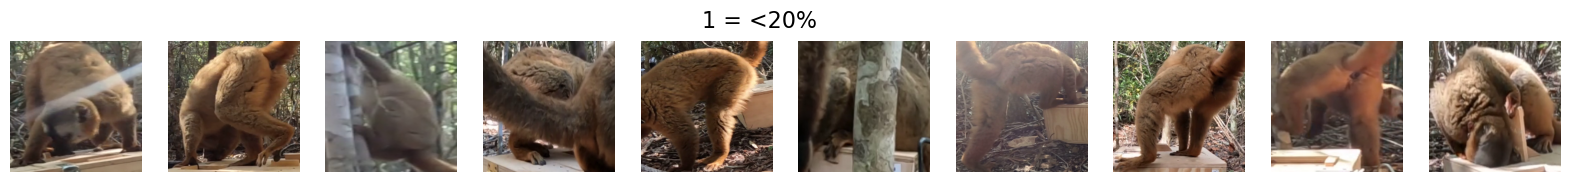

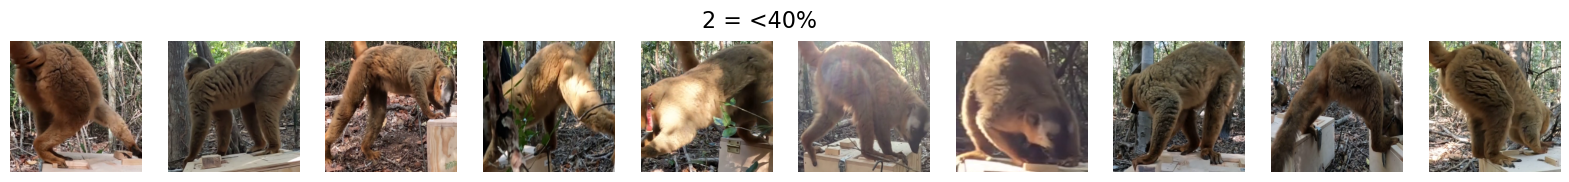

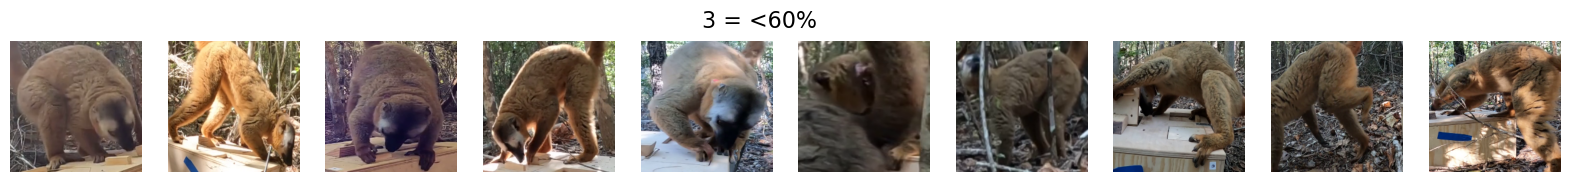

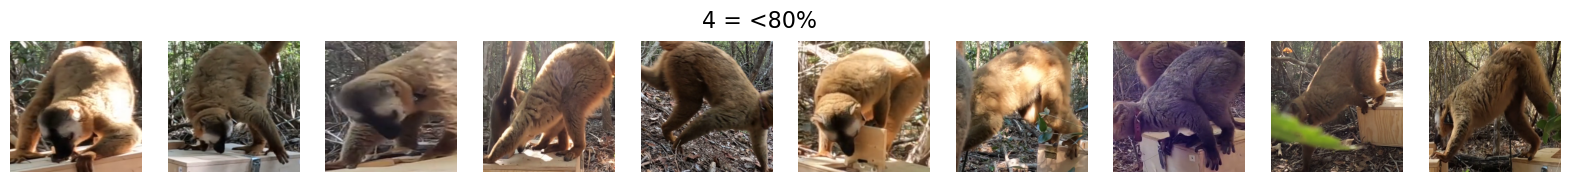

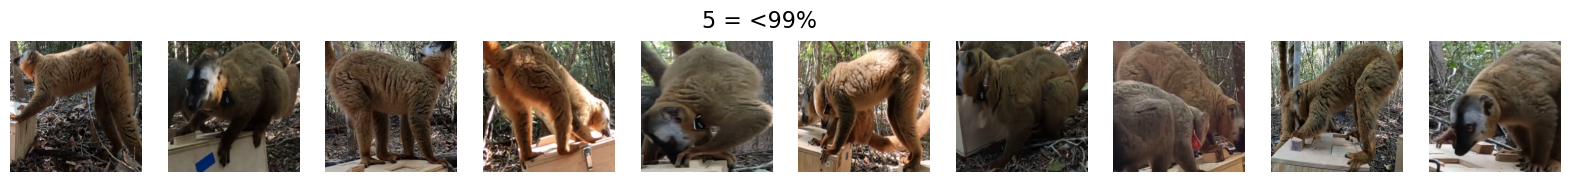

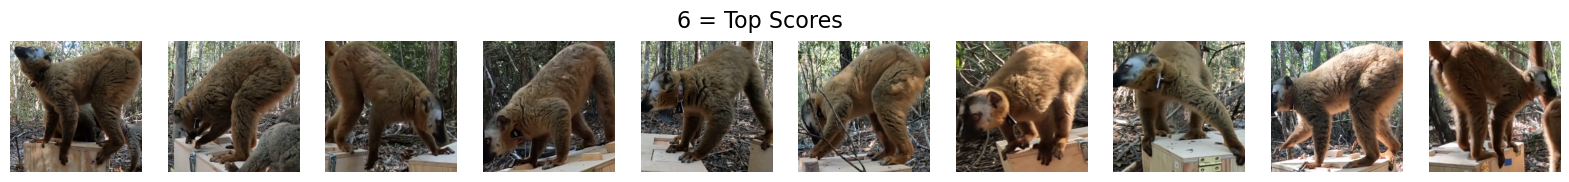

In [20]:
# Sample 10 images from each quintile DataFrame
sampled_quintile_1_df = quintile_1_df.sample(n=10, random_state=0).reset_index(drop=True)
sampled_quintile_2_df = quintile_2_df.sample(n=10, random_state=0).reset_index(drop=True)
sampled_quintile_3_df = quintile_3_df.sample(n=10, random_state=0).reset_index(drop=True)
sampled_quintile_4_df = quintile_4_df.sample(n=10, random_state=0).reset_index(drop=True)
sampled_quintile_5_df = quintile_5_df.sample(n=10, random_state=0).reset_index(drop=True)
sampled_top_scores_df = top_scores_df.sample(n=10, random_state=0).reset_index(drop=True)

# Define the quintile names
quintile_names = ["1 = <20%", "2 = <40%", "3 = <60%", "4 = <80%", "5 = <99%", "6 = Top Scores"]

# List of sampled quintile DataFrames
sampled_quintiles = [sampled_quintile_1_df, sampled_quintile_2_df, sampled_quintile_3_df, sampled_quintile_4_df, sampled_quintile_5_df, sampled_top_scores_df] 
# Plot each stripe for each quintile separately
for i, sampled_quintile_df in enumerate(sampled_quintiles):
    fig, axes = plt.subplots(1, 10, figsize=(20, 2))
    fig.suptitle(quintile_names[i], fontsize=16)
    
    for j, row in sampled_quintile_df.iterrows():
        video_path = os.path.join(path_to_videos, f"{row['experiment']}.mp4")
        cap = cv2.VideoCapture(video_path)

        if not cap.isOpened():
            print(f"Error: Could not open video {video_path}")
        else:
            frame_number = int(row['trackNumber'])
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
            ret, frame = cap.read()

            if ret:
                x, y, w, h = int(row['xCoord']), int(row['yCoord']), int(row['width']), int(row['height'])
                x = max(0, x)
                y = max(0, y)
                w = min(w, 1920 - x)
                h = min(h, 1080 - y)
                cropped_frame = frame[y:y+h, x:x+w]
                resized_frame = cv2.resize(cropped_frame, (224, 224), cv2.INTER_AREA)
                axes[j].imshow(cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB))
                axes[j].axis('off')
            cap.release()

    #plt.show()
    #plt.tight_layout()
    # Make directory if it does not exist
    save_dir = "../assets/quality_examples"
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(f'{save_dir}/{quintile_names[i]}.png')


### Get top 1000 highest scored images

In [17]:

# Convert scores to a numpy array
scores_array = np.array(scores)

# Get the indices of the top 1000 scores
top_1000_indices = np.argsort(scores_array)[-1000:]

# Get the corresponding sorted_sampled_indices for the top 1000 scores
top_1000_sorted_sampled_indices = sorted_sampled_indices[top_1000_indices]

print(top_1000_sorted_sampled_indices)

Int64Index([ 85219,  53395,   9396,  25724, 112958,  30346,  26693,  33981,
             70460,  10663,
            ...
             64603,  81492,  87848, 107392,  30044, 107398,  38010,  30050,
             30049,  30062],
           dtype='int64', length=1000)


## All in one

In [ ]:
def sample_top_1000_scores(ind_id):
    print(ind_id)

    subset_df = filtered_combined_df[filtered_combined_df['nameOrder'] == ind_id].reset_index(drop=True)

    # Convert the 'experiment' column to a numerical variable
    subset_df['experiment_num'] = subset_df['experiment'].astype('category').cat.codes
    subset_df[['xCoord_norm', 'yCoord_norm', 'width_norm', 'height_norm']] = subset_df[['xCoord', 'yCoord', 'width', 'height']].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    features = subset_df[['xCoord_norm', 'yCoord_norm', 'width_norm', 'height_norm', 'experiment_num']]
    kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(features)
    subset_df['cluster'] = kmeans.labels_

    np.random.seed(0)
    # Group by cluster and sample one index from each cluster
    sampled_indices = subset_df.groupby('cluster').apply(lambda x: x.sample(1)).index.droplevel(0)
    sorted_sampled_indices = sampled_indices.sort_values()

    # Retrieve sorting model scores from video data
    path_to_videos = f"/usr/users/vogg/sfb1528s3/B06/2023april-july/NewBoxesClosed/Converted/{group}/"

    i = 0
    scores = []


    for i in range(len(sorted_sampled_indices)):

        index = sorted_sampled_indices[i]
        if i % 1000 == 0:
            print(f"Processing row {i}")
        row = subset_df.iloc[index]
        video_path = os.path.join(path_to_videos, f"{row['experiment']}.mp4")
        cap = cv2.VideoCapture(video_path)

        if not cap.isOpened():
            print(f"Error: Could not open video {video_path}")
        else: 
            frame_number = int(row['trackNumber'])
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
            ret, frame = cap.read()

            if ret:
                # Crop the bounding box from the frame
                x, y, w, h = int(row['xCoord']), int(row['yCoord']), int(row['width']), int(row['height'])
                x = max(0, x)
                y = max(0, y)
                w = min(w, 1920 - x)
                h = min(h, 1080 - y)
                cropped_frame = frame[y:y+h, x:x+w]

                # Resize the cropped frame to 224x224
                resized_frame = cv2.resize(cropped_frame, (224, 224), cv2.INTER_AREA)

                frame = torch.from_numpy(resized_frame).float()
                frame = frame.permute(2, 0, 1)
                img = frame / 255.0

                # Add a batch dimension and move the tensor to the same device as the model
                img = img.unsqueeze(0).to(next(model.parameters()).device)

                # Apply the model to the image
                with torch.no_grad():
                    output = model(img)
                    score = output.numpy()[0][1]


                scores.append(score)
    
    # Get the indices of the top 1000 scores
    scores_array = np.array(scores)
    top_1000_indices = np.argsort(scores_array)[-1000:]
    top_1000_sorted_sampled_indices = sorted_sampled_indices[top_1000_indices]

    subset_df = subset_df.loc[top_1000_sorted_sampled_indices]
    
    return subset_df


# Apply the function sample_top_1000_scores to each 'nameOrder' and save the result as sampled_df
sampled_df = pd.concat([sample_top_1000_scores(ind_id) for ind_id in filtered_combined_df['nameOrder'].unique()])

# Get all rows for nameOrders with counts under 1000
under_n_df = combined_df[combined_df['nameOrder'].isin(under_n_nameOrders)]
# Sample either 1000 or the maximum number of samples for each 'nameOrder' in under_n_nameOrders
under_n_samples = []
for nameOrder in under_n_nameOrders:
    nameOrder_df = combined_df[combined_df['nameOrder'] == nameOrder]
    sample_size = min(1000, len(nameOrder_df))
    under_n_samples.append(nameOrder_df.sample(sample_size, random_state=0))


0


/user/vogg/miniconda3/envs/mktrack/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Processing row 0
Processing row 1000
Processing row 2000
6


/user/vogg/miniconda3/envs/mktrack/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Processing row 0
Processing row 1000
Processing row 2000
7


/user/vogg/miniconda3/envs/mktrack/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Processing row 0
Processing row 1000
Processing row 2000
3


/user/vogg/miniconda3/envs/mktrack/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Processing row 0
Processing row 1000
Processing row 2000
2


/user/vogg/miniconda3/envs/mktrack/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Processing row 0
Processing row 1000
Processing row 2000
4


/user/vogg/miniconda3/envs/mktrack/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Processing row 0
Processing row 1000
Processing row 2000


In [84]:

# Sample 1000 rows for unsure_index
unsure_df = combined_df[combined_df['nameOrder'] == unsure_index]
unsure_sample = unsure_df.sample(5000, random_state=0)


In [85]:
unsure_sample.head(10)

trackNumber trackId       xCoord      yCoord       width      height  \
279349       28675      56   376.793376  466.473887  432.436964  345.157675   
450238       14482      51   522.037699  544.768226  110.705767   97.821603   
459278       19252      65   630.629839  534.156926   90.972009   82.810656   
213702        7750      36   267.594142  504.982473   83.483004   67.519578   
192256       24139      45   776.505172  455.268249  247.365929  246.303871   
175160        3109       5  1013.777513  538.059075  452.293683  324.119165   
98921         6331      16   299.393615  593.401588  427.023313  419.933390   
424859         770       2   627.605938  548.754406   63.498619   57.693551   
98578         6563      13  1357.263865  388.850865  215.672126  247.697156   
97215         5692      12   623.233484  500.277988  395.714900  244.514125   

        confidenceTrack species  nameOrder confidenceId experiment  
279349         0.976041       0          8            0    J_e6_c2  
450238         0.945372       0          8            0    J_e5_c3  
459278         0.720086       0          8            0    J_e5_c3  
213702         0.651513       0          8            0    J_e5_c4  
192256         0.952906       0          8            0    J_e6_c1  
175160         0.990066       0          8            0    J_e6_c1  
98921          0.945166       0          8            0    J_e5_c2  
424859         0.369879       0          8            0    J_e5_c3  
98578          0.926428       0          8            0    J_e5_c2  
97215          0.968977       0          8            0    J_e5_c2

In [86]:

# Combine all sampled DataFrames if under_n_samples is not empty
if under_n_samples:
    under_n_df = pd.concat(under_n_samples, ignore_index=True)
else:
    under_n_df = pd.DataFrame(columns=combined_df.columns)

# Combine with the sampled DataFrame
under_n_df = pd.concat([under_n_df, unsure_sample], ignore_index=True)

# Combine with the sampled DataFrame
sampled_df = pd.concat([sampled_df, under_n_df], ignore_index=True)

# Reorder sampled_df by the columns experiment and trackNumber
sampled_df = sampled_df.sort_values(by=['experiment', 'trackNumber']).reset_index(drop=True)

name_order_counts = sampled_df['nameOrder'].value_counts()
name_order_counts.index = name_order_counts.index.map(lambda x: f"{orderedNames[x]} ({x})")
print(name_order_counts)

        

Unsure (8)       5000
Chennai (7)      1000
Palestina (2)    1000
Golan (6)        1000
Cambodia (0)     1000
Taji (3)         1000
Myanmar (4)      1000
Beirut (1)        309
Name: nameOrder, dtype: int64


In [87]:
sampled_df.head(10)

trackNumber trackId       xCoord      yCoord       width      height  \
0        2342       7  1458.574844  475.584798   63.322002   76.834299   
1        2677       8  1223.791018  395.231185  329.255597  333.543744   
2        2679       9  1754.967223  491.395355  171.488693  324.681627   
3        2685       9  1717.545121  478.273227  209.201688  391.494482   
4        2690       9  1659.966097  463.326499  237.299639  422.887621   
5        2693       9  1576.373734  455.496232  296.765397  487.816512   
6        2695       8  1239.334139  388.880324  273.340180  305.833612   
7        2696       9  1448.432640  442.650603  399.226812  603.533911   
8        2697       9  1432.536542  420.218390  428.151738  632.865488   
9        2702       9  1311.434506  395.387095  522.105735  656.378577   

   confidenceTrack species  nameOrder confidenceId experiment  experiment_num  \
0         0.209738       0          8            0    J_e1_c1             NaN   
1         0.985737       0          7            1    J_e1_c1             0.0   
2         0.974091       0          2            1    J_e1_c1             0.0   
3         0.978859       0          2            1    J_e1_c1             0.0   
4         0.974006       0          2            1    J_e1_c1             0.0   
5         0.840725       0          2            1    J_e1_c1             0.0   
6         0.982436       0          7            1    J_e1_c1             0.0   
7         0.668394       0          2            1    J_e1_c1             0.0   
8         0.889944       0          2            1    J_e1_c1             0.0   
9         0.869381       0          2            1    J_e1_c1             0.0   

   xCoord_norm  yCoord_norm  width_norm  height_norm  cluster  
0          NaN          NaN         NaN          NaN      NaN  
1     0.669226     0.657677    0.237912     0.250783   2369.0  
2     0.938211     0.638647    0.098586     0.260036    908.0  
3     0.920524     0.625569    0.126296     0.321024   2101.0  
4     0.893312     0.610672    0.146941     0.349680    377.0  
5     0.853804     0.602868    0.190633     0.408948   2568.0  
6     0.677027     0.650776    0.192065     0.226595   1088.0  
7     0.793337     0.590066    0.265917     0.514577    534.0  
8     0.785824     0.567709    0.287169     0.541351    604.0  
9     0.728589     0.542961    0.356202     0.562814   2062.0

In [88]:
import cv2



group_folder = os.path.join(label_root, "..", "richard_sorted", group)
os.makedirs(group_folder, exist_ok=True)

images_folder = os.path.join(group_folder, "images")
labels_with_ids_folder = os.path.join(group_folder, "labels_with_ids")

os.makedirs(images_folder, exist_ok=True)
os.makedirs(labels_with_ids_folder, exist_ok=True)

for i in range(len(sampled_df)):
    if i % 1000 == 0:
        print(f"Processing row {i}")
    row = sampled_df.iloc[i]

    # Normalize coordinates and dimensions
    xCoord_norm = (row['xCoord'] + row['width']/2) / 1920
    yCoord_norm = (row['yCoord'] + row['height']/2) / 1080
    width_norm = row['width'] / 1920
    height_norm = row['height'] / 1080

    filename = f"{row['experiment']}_{row['trackNumber']}.txt"
    file_path = os.path.join(labels_with_ids_folder, filename)

    with open(file_path, 'a') as f:
        f.write(f"0 0 {xCoord_norm} {yCoord_norm} {width_norm} {height_norm} {row['nameOrder']}\n")

    if i == 0 or row['experiment'] != sampled_df.iloc[i-1]['experiment']:
        if i > 0:
            if cap.isOpened():
                cap.release()
        video_path = os.path.join(path_to_videos, f"{row['experiment']}.mp4")
        cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
    else:
        frame_number = int(row['trackNumber'])
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = cap.read()
        if ret:
            image_filename = f"{row['experiment']}_{row['trackNumber']}.png"
            image_path = os.path.join(images_folder, image_filename)
            cv2.imwrite(image_path, frame)
            #print(f"Frame {frame_number} saved as {image_path}")
        else:
            print(f"Error: Could not read frame {frame_number}")


Processing row 0
Processing row 1000
Processing row 2000
Processing row 3000
Processing row 4000
Processing row 5000
Processing row 6000
Processing row 7000
Processing row 8000
Processing row 9000
Processing row 10000
Processing row 11000


### Make .train and .val files

In [89]:
from collections import Counter


label_list = [item for item in os.listdir(data_root / "labels_with_ids") if not item.startswith(".")]
print(len(label_list))
print(label_list[:5])

# Group by the first 7 letters of each filename
grouped_filenames = [filename[:7] for filename in label_list]
grouped_counts = Counter(grouped_filenames)

print(grouped_counts)

11035
['J_e4_c4_10027.txt', 'J_e6_c3_18479.txt', 'J_e6_c1_19012.txt', 'J_e5_c2_2338.txt', 'J_e1_c1_9300.txt']
Counter({'J_e6_c1': 1411, 'J_e5_c2': 1337, 'J_e6_c2': 1317, 'J_e5_c3': 947, 'J_e5_c1': 780, 'J_e4_c1': 622, 'J_e6_c3': 529, 'J_e5_c4': 528, 'J_e3_c2': 424, 'J_e1_c1': 410, 'J_e6_c4': 404, 'J_e4_c2': 388, 'J_e4_c4': 358, 'J_e1_c4': 337, 'J_e1_c2': 327, 'J_e3_c3': 307, 'J_e3_c4': 301, 'J_e3_c1': 167, 'J_e4_c3': 141})


In [90]:
#/usr/users/vogg/monkey-tracking-in-the-wild/src/data/

val_list = []
if group == "Alpha":
    val_list = ["A_e2_c4", "A_e5_c4", "A_e3_c3", "A_e6_c2"]
elif group == "B":
    val_list = ["B_e6_c2", "B_e3_c1", "B_e3_c4", "B_e4_c1"]
elif group == "J":
    val_list = ["J_e1_c2", "J_e3_c2", "J_e4_c4", "J_e5_c4"]
elif group == "R1":
    val_list = ["R_e1_c3", "R_e2_c3", "R_e6_c4", "R_e5_c2"]
#If group is alpha then, the val_list contains A_e2_c4, A_e5_c4, A_e3_c3, A_e6_c2, if it is B then it contains "B_e6_c2", "B_e3_c1", "B_e3_c4", "B_e4_c1", if it is J then it contains "J_e1_c2", "J_e3_c2", "J_e4_c4", "J_e5_c4", if it is R1 then it contains "R_e1_c3", "R_e2_c3", "R_e6_c4", "R_e5_c2"
# Alpha: val (A_e2_c4, A_e5_c4, A_e3_c3, A_e6_c2)
# B: val ("B_e6_c2", "B_e3_c1", "B_e3_c4", "B_e4_c1")
# J: val ("J_e1_c2", "J_e3_c2", "J_e4_c4", "J_e5_c4")
# R1: val ("R_e1_c3", "R_e2_c3", "R_e6_c4", "R_e5_c2")

for img_id in label_list:
    if not img_id.startswith(".") and not any(img_id.startswith(prefix) for prefix in val_list):
        label_fpath = data_root / f"lemur_ids_sorted_{group}.train"

        label_str = data_root.name + "/images/" + img_id.replace("txt", "png") + "\n"

        with open(label_fpath, 'a') as f:
            f.write(label_str)

for img_id in label_list:
    if not img_id.startswith(".") and any(img_id.startswith(prefix) for prefix in val_list):
        label_fpath = data_root / f"lemur_ids_sorted_{group}.val"

        label_str = data_root.name + "/images/" + img_id.replace("txt", "png") + "\n"

        with open(label_fpath, 'a') as f:
            f.write(label_str)